In [1]:
import os
import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision.datasets import ImageFolder
from torchvision.io import read_image, ImageReadMode
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import random
from tqdm.notebook import tqdm

In [2]:
torch.manual_seed(1337)

In [3]:
images_dir = "../images"
os.makedirs(images_dir + "/positive", exist_ok=True)
os.makedirs(images_dir + "/negative", exist_ok=True)

In [30]:
# generate_df_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=random.uniform(0, 1)),
#     transforms.RandomVerticalFlip(p=random.uniform(0, 1)),
#     transforms.RandomRotation(degrees=random.uniform(1, 50)),
#     transforms.ColorJitter(
#         brightness=random.uniform(0.6, 1.4),
#         contrast=random.uniform(0.6, 1.4),
#         saturation=random.uniform(0.6, 1.4),
#         hue=random.uniform(0.01, 0.1)
#     ),
#     transforms.GaussianBlur(kernel_size=random.choice([3, 5])),
#     transforms.Resize((128, 128)),
# ])

In [31]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

In [32]:

def generate_augmented_data(images_dir, output_dir, num_augmented_images=10, label=None):
    for filename in os.listdir(images_dir):
        if filename == ".gitkeep":
            continue
        # Load the image
        image_path = os.path.join(images_dir, filename)
        image = Image.open(image_path)

        for i in range(num_augmented_images):
            # Apply the transformations
            augmented_image = transform(image)
            output_filename = f"{os.path.splitext(filename)[0]}_augmented_{i}.png"
            output_path = os.path.join(output_dir, output_filename)
            transforms.ToPILImage()(augmented_image).save(output_path)

In [7]:
#generate_augmented_data(images_dir + "/positive", images_dir + "/positive")

In [8]:
#generate_augmented_data(images_dir + "/negative", images_dir + "/negative")

In [33]:
dataset = ImageFolder(root="../images", transform=transform)

In [34]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.transform = transform
        self.image_paths = []
        for ext in ["png", "jpg"]:
            self.image_paths += glob.glob(os.path.join(root_dir, '*', f'*.{ext}'))
        class_set = set()
        for path in self.image_paths:
            class_set.add(os.path.dirname(path))
        class_list = sorted(list(class_set))
        self.class_lbl = { cls: i for i, cls in enumerate(class_list)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = read_image(self.image_paths[idx], ImageReadMode.RGB).float()
        cls = os.path.basename(os.path.dirname(self.image_paths[idx]))
        label = self.class_lbl[cls]

        return self.transform(img), torch.tensor(label)

In [11]:
# dataset = CustomDataset("../images/", transform=transform)

In [35]:
len(dataset)

880

In [ ]:
# train_dataset = ImageFolder(root="../images", transform=transform)

In [ ]:
# train_dataset.class_to_idx

In [36]:
dataset.class_to_idx

{'negative': 0, 'positive': 1}

In [37]:
splits = [0.8, 0.1, 0.1]

In [38]:
split_sizes = []
for sp in splits[:-1]:
    split_sizes.append(int(sp * len(dataset)))
split_sizes.append(len(dataset) - sum(split_sizes))

In [39]:
split_sizes

[704, 88, 88]

In [40]:
train_set, test_set, val_set = random_split(dataset, split_sizes)

In [41]:
dataloaders = {
    "train": DataLoader(train_set, batch_size=8, shuffle=True),
    "test": DataLoader(test_set, batch_size=8, shuffle=False),
    "val": DataLoader(val_set, batch_size=8, shuffle=False)
}

In [42]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

In [43]:
model.fc = torch.nn.Linear(2048, 2)

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [45]:
EPOCHS = 5
NUM_CLASSES = len(dataset.classes)

In [46]:
NUM_CLASSES

2

In [47]:
dataset.classes

['negative', 'positive']

In [48]:
metrics = {
    "train": {"loss": [], "accuracy": []},
    "val": {"loss": [], "accuracy": []},
}

In [49]:
for epoch in range(EPOCHS):
  ep_metrics = {
    "train": {"loss": 0, "accuracy": 0, "count": 0},
    "val": {"loss": 0, "accuracy": 0, "count": 0},
  }

  print(f"Epoch {epoch}")

  for phase in ["train", "val"]:
    print(f"-------- {phase} --------")
    for images, labels in tqdm(dataloaders[phase]):
      optimizer.zero_grad()

      with torch.set_grad_enabled(phase == "train"):
        output = model(images.to(device))
        ohe_label = nn.functional.one_hot(labels,num_classes=NUM_CLASSES)

        loss = criterion(output, ohe_label.float().to(device))

        correct_preds = labels.to(device) == torch.argmax(output, dim=1)
        accuracy = (correct_preds).sum()/len(labels)

      if phase == "train":
        loss.backward()
        optimizer.step()

      ep_metrics[phase]["loss"] += loss.item()
      ep_metrics[phase]["accuracy"] += accuracy.item()
      ep_metrics[phase]["count"] += 1
  
    ep_loss = ep_metrics[phase]["loss"]/ep_metrics[phase]["count"]
    ep_accuracy = ep_metrics[phase]["accuracy"]/ep_metrics[phase]["count"]

    print(f"Loss: {ep_loss}, Accuracy: {ep_accuracy}\n")

    metrics[phase]["loss"].append(ep_loss)
    metrics[phase]["accuracy"].append(ep_accuracy)
torch.save(model.state_dict(), "../models/face_reco_classifier.pt")  

Epoch 0
-------- train --------


  0%|          | 0/88 [00:00<?, ?it/s]

Loss: 0.32906773177356546, Accuracy: 0.8892045454545454

-------- val --------


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 0.18594480102712457, Accuracy: 0.9772727272727273

Epoch 1
-------- train --------


  0%|          | 0/88 [00:00<?, ?it/s]

Loss: 0.23396813290574672, Accuracy: 0.890625

-------- val --------


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 0.09611428799954327, Accuracy: 0.9659090909090909

Epoch 2
-------- train --------


  0%|          | 0/88 [00:00<?, ?it/s]

Loss: 0.10718707487566545, Accuracy: 0.9431818181818182

-------- val --------


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 0.09564227654217658, Accuracy: 0.9545454545454546

Epoch 3
-------- train --------


  0%|          | 0/88 [00:00<?, ?it/s]

Loss: 0.1497964385615143, Accuracy: 0.9318181818181818

-------- val --------


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 0.1452851193872365, Accuracy: 0.9318181818181818

Epoch 4
-------- train --------


  0%|          | 0/88 [00:00<?, ?it/s]

Loss: 0.20035480777468448, Accuracy: 0.921875

-------- val --------


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 0.056047866798259995, Accuracy: 0.9772727272727273



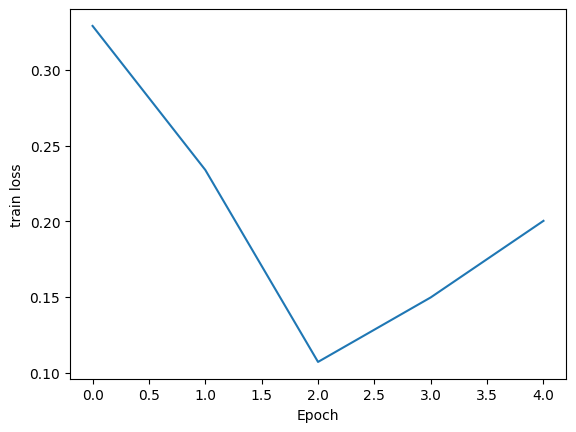

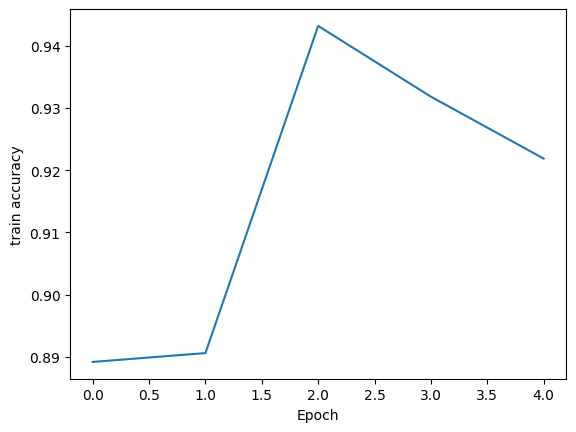

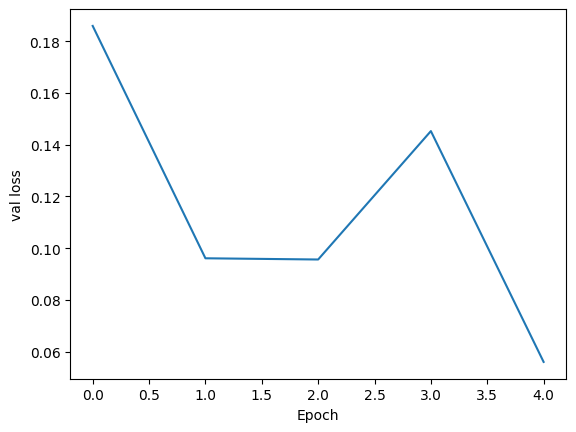

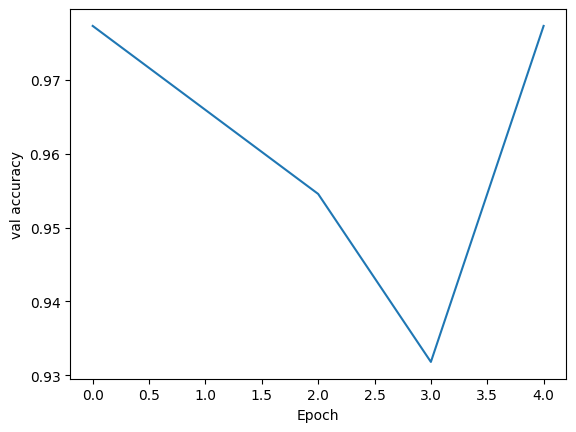

In [50]:
for phase in metrics:
    for metric in metrics[phase]:
        metric_data = metrics[phase][metric]
        plt.plot(range(len(metric_data)), metric_data)
        plt.xlabel("Epoch")
        plt.ylabel(f"{phase} {metric}")
        plt.show()

In [51]:
preds = []
actual = []

tot_loss = tot_acc = count = 0

for images, labels in tqdm(dataloaders["test"]):
    with torch.set_grad_enabled(False):
        output = model(images.to(device))
        ohe_label = nn.functional.one_hot(labels, num_classes=NUM_CLASSES)
        out_labels = torch.argmax(output, dim=1)


        tot_loss += criterion(output, ohe_label.float().to(device))
        tot_acc += (labels.to(device) == out_labels).sum()/len(labels)
        count += 1

    preds += out_labels.tolist()
    actual += labels.tolist()

print(f"Test Loss: {tot_loss / count}, Test Accuracy: {tot_acc / count}")

  0%|          | 0/11 [00:00<?, ?it/s]

Test Loss: 0.11682678014039993, Test Accuracy: 0.9318181872367859


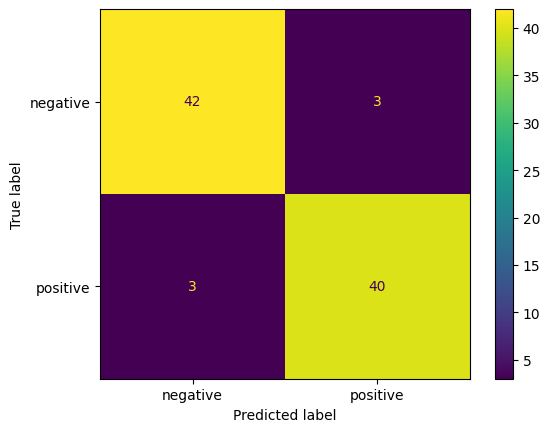

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_labels = sorted(test_set.dataset.class_to_idx, key=lambda cls: test_set.dataset.class_to_idx[cls])

cm = confusion_matrix(actual, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot()
plt.show()

In [53]:
class_labels = sorted(test_set.dataset.class_to_idx, key=lambda cls: test_set.dataset.class_to_idx[cls])

In [54]:
class_labels

['negative', 'positive']

In [57]:
import numpy as np
cm_np = np.array(cm)
stats = pd.DataFrame(index=class_labels)

In [58]:
stats

""
negative
positive
